# Image classifier for the SVHN dataset

### Instructions

In this project, you will develop feedforward/MLP and convolutional neural network classifier models for the Street View House Numbers (SVHN) dataset. Your task is to build, train, validate, evaluate and save deep learning classifier models, trained on the SVHN dataset. You will preprocess the dataset ready for training, and develop both MLP and CNN models from scratch. You will build, compile and train these models, implementing model validation and using callbacks. You will save the best preforming models, and get predictions from each on unseen test data.

### Let's get started!

We'll start by running some imports, and loading the dataset.

![SVHN overview image](http://ufldl.stanford.edu/housenumbers/32x32eg.png)

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train_32x32.mat) and [here](http://ufldl.stanford.edu/housenumbers/test_32x32.mat). Once downloaded, you will have two files: `train_32x32.mat` and `test_32x32.mat`.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

import os
 
data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

! wget -qO data/train_32x32.mat "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"

! wget -qO data/test_32x32.mat "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"

In [1]:
import tensorflow as tf
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)

2.2.0


In [2]:
from scipy.io import loadmat

# Run this cell to load the dataset
train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
import numpy as np

# Extract the images and labels separately 
# and rescale the pixel values
def load_svhn_data(train, test):
    """
    This function takes in the train and test dataset as loaded in the
    cell above.Then, it extracts the images and labels separately, and 
    scales the images so that their values lie in the range [0, 1].
    This function returns a tuple (train_images, train_labels), 
    (test_images, test_images) of the train and test dataset.
    """
    train_images = np.moveaxis(train['X'], -1, 0)
    train_images = train_images / np.amax(train_images)
    train_labels = np.squeeze(train['y'])
    test_images = np.moveaxis(test['X'], -1, 0)
    test_images = test_images / np.amax(test_images)
    test_labels = np.squeeze(test['y'])
    # Change the label of 10 to 0
    train_labels = np.where(train_labels==10, 0, train_labels)
    test_labels = np.where(test_labels==10, 0, test_labels)
    return (train_images, train_labels), (test_images, test_labels)
    
(train_images, train_labels), (test_images, test_labels) = \
    load_svhn_data(train, test)

print("Train_images shape: ", train_images.shape)
print("Train_labels shape: ", train_labels.shape)
print("Test_images shape: ", test_images.shape)
print("Test_labels shape: ", test_labels.shape)
print("The normalize images value: Min = {}, Max = {}".format(
    train_images.min(), train_images.max()))

Train_images shape:  (73257, 32, 32, 3)
Train_labels shape:  (73257,)
Test_images shape:  (26032, 32, 32, 3)
Test_labels shape:  (26032,)
The normalize images value: Min = 0.0, Max = 1.0


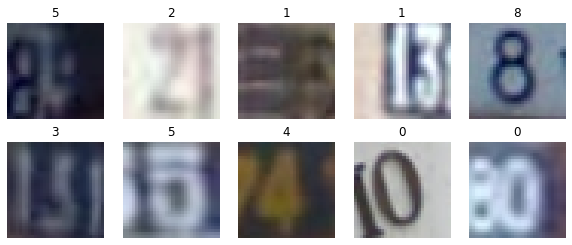

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot a random image and its label
def plot_images(images, labels, cmap=None):
    """
    This function takes 10 images and corresponding labels and display
    them in a figure.
    """
    fig = plt.figure(figsize=(10, 4))
    for i in range(10):
        ax = fig.add_subplot(2, 5, i+1)
        ax.set_axis_off()
        ax.imshow(np.squeeze(images[i]), cmap=cmap)
        ax.set_title(labels[i])

# Choose random 10 samples of train dataset
rand_idx = np.random.choice(train_labels.shape[0], 10)
images, labels = train_images[rand_idx], train_labels[rand_idx]

# Plot the images and labels
plot_images(images, labels)

In [5]:
def rgb2gray(image):
    """
    This function converts the image to grayscale by taking the 
    average across all colour channels for each pixel, and retains the
    channel dimension, which have size 1.
    """
    image = np.mean(image, axis=-1)
    return np.expand_dims(image, axis=3)

# Convert the RGB images of train and test to grayscale
train_images_gray = rgb2gray(train_images)
test_images_gray = rgb2gray(test_images)

print("Grayscale train_images shape: ", train_images_gray.shape)
print("Grayscale test_images shape: ", test_images_gray.shape)

Grayscale train_images shape:  (73257, 32, 32, 1)
Grayscale test_images shape:  (26032, 32, 32, 1)


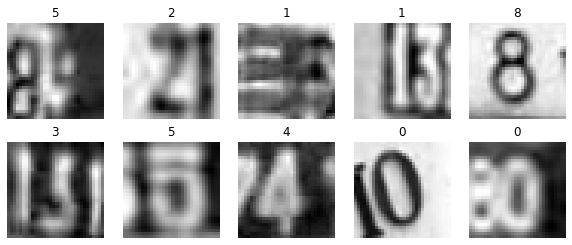

In [6]:
# Display the random samples of the grayscale images 
# and corresponding labels
images, labels = train_images_gray[rand_idx], train_labels[rand_idx]
plot_images(images, labels, cmap='gray')

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import regularizers

# Build a MLP classifier
def get_MLP_classifier():
    """
    This function should build a Sequential MLP model according to the
    above specification. Ensure the weights are initialised by
    providing the input_shape argument in the first layer. 
    This function also compile the model with the Adam optimiser, 
    sparse categorical cross entropy loss function, 
    and a single accuracy metric.
    """
    model = Sequential([
        Flatten(input_shape=train_images_gray[0].shape),
        Dense(256, activation='relu',
            kernel_regularizer=regularizers.l1(3e-5)),
        Dense(64, activation='relu',
            kernel_regularizer=regularizers.l1(3e-5)),
        Dense(10, activation='softmax')])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

# Run the function to create the classifier model
MLP_model = get_MLP_classifier()

# Print out the model summary
MLP_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 279,498
Trainable params: 279,498
Non-trainable params: 0
_________________________________________________________________


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, \
    ReduceLROnPlateau

def get_checkpoint_best_only(filepath):
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation
      accuracy.
    - generates a file called 'MLP_checkpoint_best_only/checkpoint'
    """
    return ModelCheckpoint(filepath=filepath, save_weights_only=True,
        save_freq='epoch', monitor='val_accuracy', 
        save_best_only=True, verbose=1)

def get_reduce_lr():
    """
    This function should return a ReduceLROnPlateau callback that
    allows reduction of the learning rate when the validation loss
    has stopped improving.
    """
    return ReduceLROnPlateau(monitor='val_loss', patience=1, 
        factor=0.9, verbose=1)

In [9]:
# Compute and display the loss and accuracy of model on the test set
def get_test_loss_accuracy(model, test_images, test_labels):
    """
    Test model classification loss & accuracy
    """
    test_loss, test_acc = model.evaluate(
        x=test_images, y=test_labels, verbose=0)
    print("Test loss: {:0.4f} \nTest accuracy: {:0.4f}".format(
        test_loss, test_acc))

In [10]:
import pandas as pd

# Plot the learning curves for loss vs epoch and accuracy vs epoch
# for both training and validation loss
def plot_history(history):
    df = pd.DataFrame(history.history)
    epoch = np.arange(1, len(df)+1)
    fig = plt.figure(figsize=(12, 4))
    # Loss plot
    ax = fig.add_subplot(121)
    ax.plot(epoch, df['loss'], label='Training')
    ax.plot(epoch, df['val_loss'], label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title("Loss vs Epoch")
    ax.legend()
    # Accuracy plot
    ax = fig.add_subplot(122)
    ax.plot(epoch, df['accuracy'], label='Training')
    ax.plot(epoch, df['val_accuracy'], label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title("Accuracy vs Epoch")
    ax.legend()
    plt.show()

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plot the confusion matrix and print classification report
def plot_confusion_matrix(model, test_images, test_labels):
    """
    This function computes and displays the confusion matrix and 
    classification report of model on the test set.
    """
    # Get prediction labels
    pred_labels = np.argmax(model.predict(test_images), axis=1)

    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(test_labels, pred_labels)

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cf_matrix/np.sum(cf_matrix, axis=1), ax=ax, 
        annot=True, cmap='Reds', fmt='.1%', square=True);
    plt.title("Confusion matrix(%) for test set")
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

    cls_report = classification_report(test_labels, pred_labels, 
        digits=4)
    print(cls_report)

Epoch 1/30
1139/1145 [============================>.] - ETA: 0s - loss: 2.2920 - accuracy: 0.2149
Epoch 00001: val_accuracy improved from -inf to 0.35476, saving model to MLP_checkpoints_best_only/checkpoint
1145/1145 [==============================] - 4s 3ms/step - loss: 2.2900 - accuracy: 0.2156 - val_loss: 1.9118 - val_accuracy: 0.3548 - lr: 0.0010
Epoch 2/30
1131/1145 [============================>.] - ETA: 0s - loss: 1.5835 - accuracy: 0.4830
Epoch 00002: val_accuracy improved from 0.35476 to 0.53695, saving model to MLP_checkpoints_best_only/checkpoint
1145/1145 [==============================] - 4s 3ms/step - loss: 1.5812 - accuracy: 0.4839 - val_loss: 1.4996 - val_accuracy: 0.5370 - lr: 0.0010
Epoch 3/30
1128/1145 [============================>.] - ETA: 0s - loss: 1.2942 - accuracy: 0.6054
Epoch 00003: val_accuracy improved from 0.53695 to 0.59654, saving model to MLP_checkpoints_best_only/checkpoint
1145/1145 [==============================] - 4s 3ms/step - loss: 1.2926 - accu

Epoch 24/30
1133/1145 [============================>.] - ETA: 0s - loss: 0.8071 - accuracy: 0.7760
Epoch 00024: val_accuracy did not improve from 0.75146

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0004304672533180565.
1145/1145 [==============================] - 4s 3ms/step - loss: 0.8066 - accuracy: 0.7761 - val_loss: 0.9430 - val_accuracy: 0.7450 - lr: 4.7830e-04
Epoch 25/30
1127/1145 [============================>.] - ETA: 0s - loss: 0.7951 - accuracy: 0.7803
Epoch 00025: val_accuracy did not improve from 0.75146

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.00038742052274756136.
1145/1145 [==============================] - 4s 3ms/step - loss: 0.7956 - accuracy: 0.7805 - val_loss: 0.9241 - val_accuracy: 0.7493 - lr: 4.3047e-04
Epoch 26/30
1133/1145 [============================>.] - ETA: 0s - loss: 0.7894 - accuracy: 0.7840
Epoch 00026: val_accuracy improved from 0.75146 to 0.75261, saving model to MLP_checkpoints_best_only/checkpoint

Epoch 00026: Red

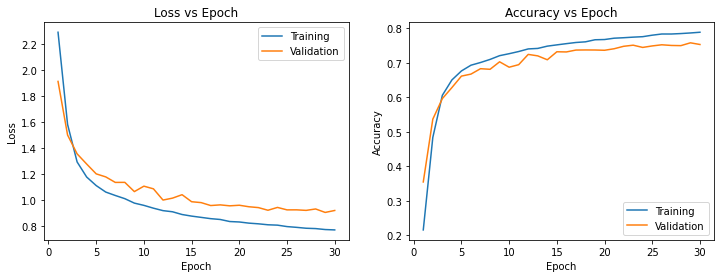

Test loss: 0.9195 
Test accuracy: 0.7535


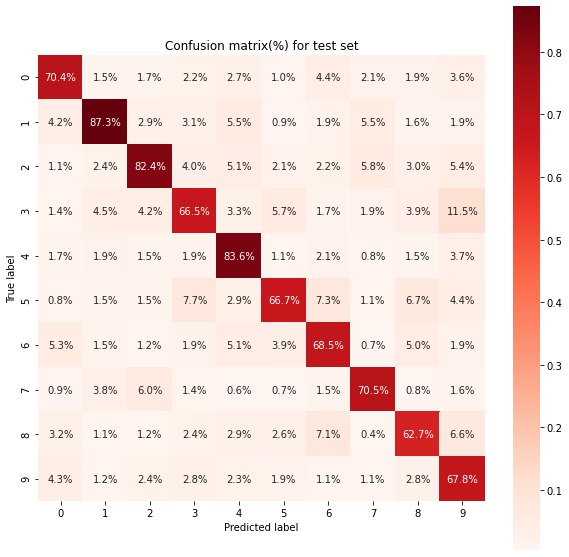

              precision    recall  f1-score   support

           0     0.7548    0.7041    0.7286      1744
           1     0.8193    0.8729    0.8452      5099
           2     0.7844    0.8243    0.8039      4149
           3     0.7094    0.6648    0.6864      2882
           4     0.7336    0.8359    0.7814      2523
           5     0.7699    0.6665    0.7145      2384
           6     0.7005    0.6849    0.6926      1977
           7     0.7837    0.7053    0.7424      2019
           8     0.6982    0.6271    0.6607      1660
           9     0.6251    0.6784    0.6506      1595

    accuracy                         0.7535     26032
   macro avg     0.7379    0.7264    0.7306     26032
weighted avg     0.7530    0.7535    0.7518     26032



In [12]:
# Train model using the created callbacks
checkpoint_best_path = "MLP_checkpoints_best_only/checkpoint"
checkpoint_best_only = get_checkpoint_best_only(checkpoint_best_path)
reduce_lr = get_reduce_lr()

callbacks = [checkpoint_best_only, reduce_lr]

# Train the model, with test data reserved for validation
history = MLP_model.fit(x=train_images_gray, y=train_labels,
    validation_data=(test_images_gray, test_labels), 
    batch_size=64, epochs=30, callbacks=callbacks)

# Finally, we plot training and validation loss and accuracy to 
# observe how the performance of model improves over time.
plot_history(history)

# Evaluate the model on the test set
get_test_loss_accuracy(MLP_model, test_images_gray, test_labels)

# Visualize the normalized confusion matrix and classification report
plot_confusion_matrix(MLP_model, test_images_gray, test_labels)

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, \
    BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

# Build a CNN classifier
def get_CNN_classifier():
    """
    This function should build a Sequential CNN model according to 
    the above specification. Ensure the weights are initialised by
    providing the input_shape argument in the first layer. 
    This function also compile the model with the Adam optimiser, 
    sparse categorical cross entropy loss function, 
    and a single accuracy metric.
    """
    model = Sequential([
        Conv2D(16, kernel_size=3, activation='relu', padding='SAME',
            input_shape=train_images[0].shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=2),
        Conv2D(32, kernel_size=3, activation='relu', padding='SAME'),
        BatchNormalization(),
        MaxPooling2D(pool_size=2),
        Flatten(),
        Dropout(0.3),
        Dense(64, activation='relu',
            kernel_regularizer=regularizers.l1(3e-4)),
        Dense(10, activation='softmax')])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

# Run the function to create the classifier model
CNN_model = get_CNN_classifier()

# Print out the model summary
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

Epoch 1/30
1145/1145 [==============================] - ETA: 0s - loss: 1.4594 - accuracy: 0.7198
Epoch 00001: val_accuracy improved from -inf to 0.83121, saving model to CNN_checkpoints_best_only/checkpoint
1145/1145 [==============================] - 22s 19ms/step - loss: 1.4594 - accuracy: 0.7198 - val_loss: 0.9707 - val_accuracy: 0.8312 - lr: 0.0010
Epoch 2/30
1137/1145 [============================>.] - ETA: 0s - loss: 0.8509 - accuracy: 0.8518
Epoch 00002: val_accuracy did not improve from 0.83121
1145/1145 [==============================] - 6s 5ms/step - loss: 0.8503 - accuracy: 0.8520 - val_loss: 0.9389 - val_accuracy: 0.8208 - lr: 0.0010
Epoch 3/30
1145/1145 [==============================] - ETA: 0s - loss: 0.7763 - accuracy: 0.8659
Epoch 00003: val_accuracy improved from 0.83121 to 0.86470, saving model to CNN_checkpoints_best_only/checkpoint
1145/1145 [==============================] - 6s 5ms/step - loss: 0.7763 - accuracy: 0.8659 - val_loss: 0.7698 - val_accuracy: 0.8647 -

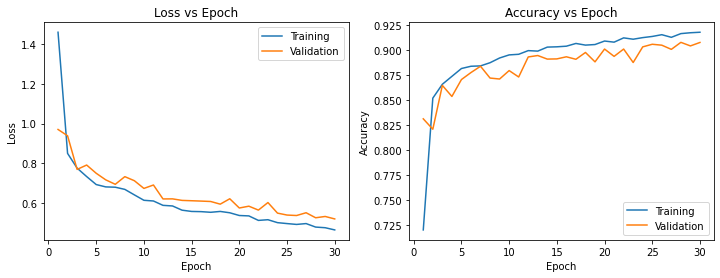

Test loss: 0.5209 
Test accuracy: 0.9078


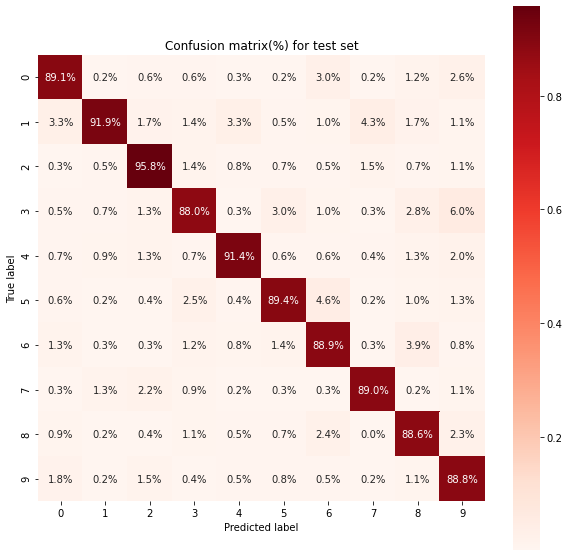

              precision    recall  f1-score   support

           0     0.9024    0.8911    0.8967      1744
           1     0.9538    0.9192    0.9362      5099
           2     0.9094    0.9581    0.9331      4149
           3     0.8971    0.8803    0.8886      2882
           4     0.9272    0.9140    0.9206      2523
           5     0.9170    0.8943    0.9055      2384
           6     0.8668    0.8887    0.8776      1977
           7     0.9210    0.8895    0.9050      2019
           8     0.8637    0.8855    0.8745      1660
           9     0.8306    0.8884    0.8585      1595

    accuracy                         0.9078     26032
   macro avg     0.8989    0.9009    0.8996     26032
weighted avg     0.9086    0.9078    0.9079     26032



In [14]:
# Train model using the created callbacks
checkpoint_best_path = "CNN_checkpoints_best_only/checkpoint"
checkpoint_best_only = get_checkpoint_best_only(checkpoint_best_path)
reduce_lr = get_reduce_lr()

callbacks = [checkpoint_best_only, reduce_lr]

# Train the model, with test data reserved for validation
history = CNN_model.fit(x=train_images, y=train_labels,
    validation_data=(test_images, test_labels), 
    batch_size=64, epochs=30, callbacks=callbacks)

# Finally, we plot training and validation loss and accuracy to 
# observe how the performance of model improves over time.
plot_history(history)

# Evaluate the model on the test set
get_test_loss_accuracy(CNN_model, test_images, test_labels)

# Visualize the normalized confusion matrix and classification report
plot_confusion_matrix(CNN_model, test_images, test_labels)

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [15]:
# Load the best weights for MLP and CNN models

# Create a new instance of the model
del MLP_model
MLP_model = get_MLP_classifier()

del CNN_model
CNN_model = get_CNN_classifier()

# Load the weights with the highest validation accuracy
MLP_model.load_weights("MLP_checkpoints_best_only/checkpoint");
CNN_model.load_weights("CNN_checkpoints_best_only/checkpoint");

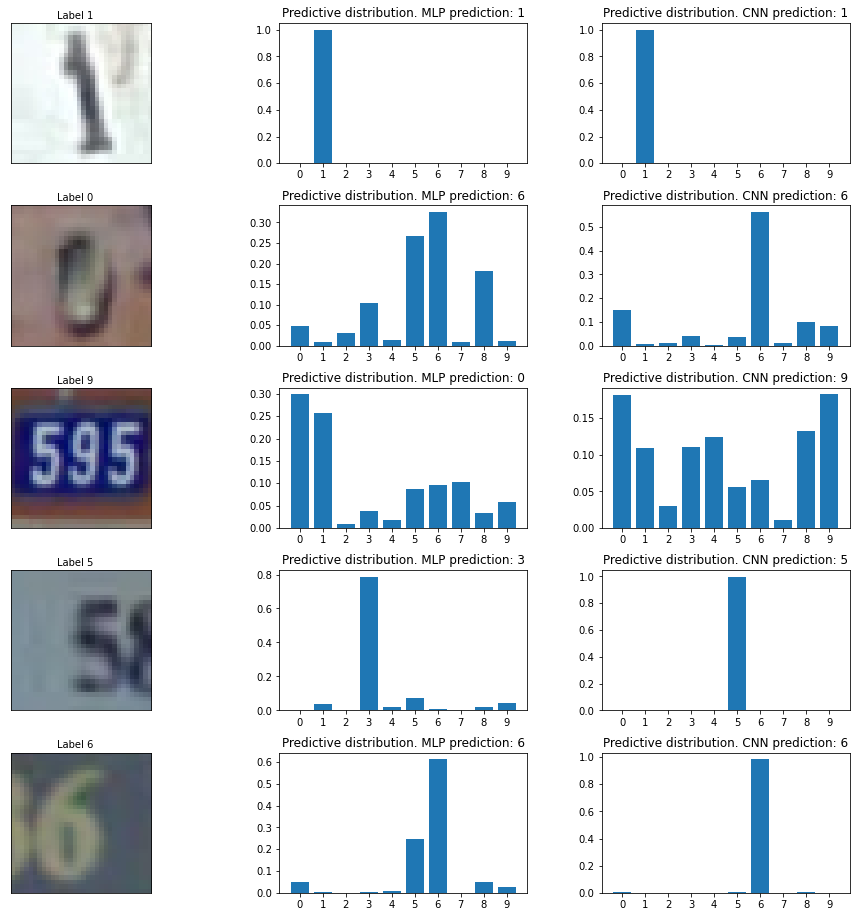

In [16]:
# Model's predictive distribution on randomly selected test images
    
num_test_images = test_images.shape[0]
random_idx = np.random.choice(num_test_images, 5)
random_test_images = test_images[random_idx, ...]
random_test_images_gray = test_images_gray[random_idx, ...]
random_test_labels = test_labels[random_idx, ...]

MLP_pred = MLP_model.predict(random_test_images_gray)
CNN_pred = CNN_model.predict(random_test_images)

fig, axes = plt.subplots(5, 3, figsize=(16, 16))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, (pred1, pred2, image, label) in enumerate(
    zip(MLP_pred, CNN_pred, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f"Label {label}")
    axes[i, 1].bar(np.arange(len(pred1)), pred1)
    axes[i, 1].set_xticks(np.arange(len(pred1)))
    axes[i, 1].set_title(f"Predictive distribution. MLP prediction: {np.argmax(pred1)}")
    axes[i, 2].bar(np.arange(len(pred2)), pred2)
    axes[i, 2].set_xticks(np.arange(len(pred2)))
    axes[i, 2].set_title(f"Predictive distribution. CNN prediction: {np.argmax(pred2)}")
plt.show()

In [17]:
# Clear directory
! rm -rf MLP_checkpoints_best_only CNN_checkpoints_best_only